## Review Previous Results
Review [Node_Classification_with_MLP.ipynb](Node_Classification_with_MLP.ipynb) before running this notebook to familiarize yourself with the problem. 

Recall, we are working with the **Cora dataset**, which consists of scientific papers, where nodes represent documents, and edges represent citation relationships. Each paper is categorized into one of several research fields.

The **Cora** dataset also includes "bag-of-words" (BoW) representations as node features.

In the Cora dataset loaded in this notebook:

- Each node in the graph represents a scientific paper.
- The node features represent the content of these papers.
- These content features are represented as a bag-of-words (BoW). Each element in the BoW vector represents the presence (1) or absence (0) of a specific word in the paper. After normalization, 1 will be changed to its proportion.


Recall, the results using MLP were:
- Training data: `Epoch: 200, Loss: 0.4827, Acc: 0.900`
- Test data: `Loss: 1.2899, Test Acc: 0.574`

## GCNConv Model Results
Here, we convert the MLP model to a GNN by swapping the two `torch.nn.Linearlayers` with two `torch_geometric.nn.GCNConv` layers. The rest of model configuration remains the same (relu, dropout, etc.). The new results illustrate the power of GNNs, where relational information plays a key role in improving performance. Additionally, we visulize the GNN embeddigns and observe that they produce a reasonable clustering of the nodes in accordance with their observed category.
- Training data: `Epoch: 200, Loss: 0.3278, Acc: 0.986`
- Test data: `Loss: 0.7819, Test Acc: 0.813`

## GATConv Model Results
We replace the two `torch_geometric.nn.GCNConv` layers with `torch_geometric.nn.GATConv` layers. Additionally, there is a dropout layer that operates on the input features at the beginning of the model. Additionally, we predict over both the validation and test sets. Here are the loss  accuracy scores:

**Single attention head** `Epoch: 200, Loss: 0.3873, Val Acc: 0.768, Test Acc: 0.805`

**8 attention heads** `Epoch: 200, Loss: 0.3099, Val Acc: 0.806, Test Acc: 0.823`

Clearly, multi-headed attention improves performance.

## GCNConv vs GATConv
See the discussion in the last cell of this notebook. Briefly, the choice between GCNConv and GATConv depends on the specific characteristics of your graph data and the requirements of your task. If your graph has simple relationships and homophily holds, GCNConv might suffice and be computationally efficient. However, if you need to capture complex relationships and adaptively weigh the importance of neighbors, GATConv is a more suitable choice, albeit with higher computational cost. The choice should be driven by the problem you are trying to solve and the nature of your graph data.

In [1]:
import collections
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.manifold import TSNE

import torch
import torch.nn.functional as F
from torch.nn import Linear

from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv, GATConv
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.utils import to_networkx

In [2]:
def visualize_graph(G, color):
    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                     node_color=color, cmap="tab10", node_size=5)

def visualize_embedding(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())
    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])
    plt.scatter(z[:, 0], z[:, 1], s=50, c=color, cmap="Set2")

## Load and inspect the data

In [3]:
# features are normalized!
dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())

In [4]:
!ls data/Planetoid/Cora/

processed raw


In [5]:
print(f"Dataset: {dataset}")
print(f"Number of graphs: {len(dataset)}")
print(f"Number of features: {dataset.num_features}")
print(f"Number of classes: {dataset.num_classes}")

Dataset: Cora()
Number of graphs: 1
Number of features: 1433
Number of classes: 7


In [6]:
data = dataset[0]
print(f"Number of nodes: {data.num_nodes}")
print(f"Number of edges: {data.num_edges}")
print(f"Average node degree: {data.num_edges/data.num_nodes}")
print(f"Number of training nodes: {data.train_mask.sum()}")
print(f"Proportion of labeled (training) nodes: {int(data.train_mask.sum()) / data.num_nodes: .2f}")
print(f"Has isolated nodes: {data.has_isolated_nodes()}")
print(f"Has self-loops: {data.has_self_loops()}")
print(f"Is undirected: {data.is_undirected()}")

Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.8980797636632203
Number of training nodes: 140
Proportion of labeled (training) nodes:  0.05
Has isolated nodes: False
Has self-loops: False
Is undirected: True


In [7]:
data

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [8]:
def inspect_label_count(data, mask_type):
    if mask_type == "train":
        labels = data.y[data.train_mask]
    elif mask_type == "val":
        labels = data.y[data.val_mask]
    else:
        labels = data.y[data.test_mask]
    counts = collections.Counter(labels.detach().numpy())
    total = len(labels)
    return(total, counts)

total, counts = inspect_label_count(data, "train")
print(total)
print(counts)

140
Counter({3: 20, 4: 20, 0: 20, 2: 20, 1: 20, 5: 20, 6: 20})


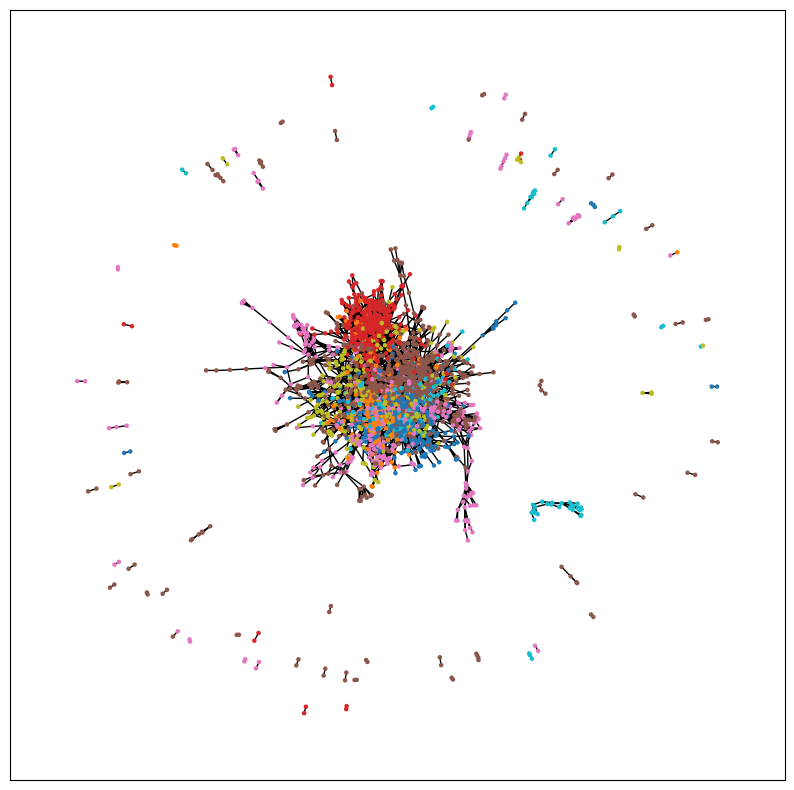

In [9]:
G = to_networkx(data, to_undirected=True)
visualize_graph(G, color=data.y)

## Graph Neural Network - GCNConv

We can easily convert the MLP model to a GNN by swapping the `torch.nn.Linear` layers with PyG's GNN operators. Specifically, we replace the linear layers by [`GCNConv`](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.conv.GCNConv.html). 

To recap, the GCN layer ([Kipf et al. (2017)](https://arxiv.org/abs/1609.02907)) is defined as  

$$
\mathbf{x}_v^{(\ell + 1)} = \mathbf{W}^{(\ell + 1)} \sum_{u \in \mathcal{N}(v) \, \cup \, \{ v \}} \frac{1}{c_{u,v}} \cdot \mathbf{x}_u^{(\ell)}
$$

where $\mathbf{W}^{(\ell + 1)}$ denotes a trainable weight matrix of shape `[num_output_features, num_input_features]` and $c_{u,v}$ refers to a fixed normalization coefficient for each edge.
In contrast, a single `Linear` layer is defined as

$$
\mathbf{x}_v^{(\ell + 1)} = \mathbf{W}^{(\ell + 1)} \mathbf{x}_v^{(\ell)}
$$

which does not make use of neighboring node information.

Note that in [Karate_Club_Node_GCN_Classifier.ipynb](../intro/Karate_Club_Node_GCN_Classifier.ipynb), I used $\mathbf{h}_u$ (instead of $\mathbf{x}_u$) to denote the embedding vector, because the former was the symbol used in [Graph Representation Learning by William L. Hamilton](https://www.cs.mcgill.ca/~wlh/grl_book/). I also used $k$ in place of $\ell$ to stay consistent with the "k-hops" naming convention. But these all mean the same things.

Because the model has a dropout layer which behaves differently during training and validation, we need to be careful and use `model.train()` and `model.eval()` in the correct places.

The `torch.nn.CrossEntropyLoss` function is designed to work with predicted logits and target class labels (or probabilities), and it automatically applies the softmax function to the logits internally before computing the loss.

In [10]:
feature_size = data.num_features
hidden_size = 16
num_classes = dataset.num_classes

class GCN(torch.nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(feature_size, hidden_size)
        self.conv2 = GCNConv(hidden_size, num_classes)
    def forward(self, x, edge_index):
        """If we use dropout, we boost performance. 
        Try uncommenting the next lines."""
        # x = F.dropout(x, p=0.5, training=self.training)
        h = self.conv1(x, edge_index)
        h = h.relu()
        h = F.dropout(h, p=0.5, training=self.training)
        logits = self.conv2(h, edge_index)
        return logits

model = GCN(hidden_size)
print(model)

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)


### Visualize node embeddings from the **UNTRAINED** GCN model
Use [**TSNE**](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) to embed the 7-dimensional node embeddings (logits vectors) onto a 2D plane. Not good! Can we do better once we train?

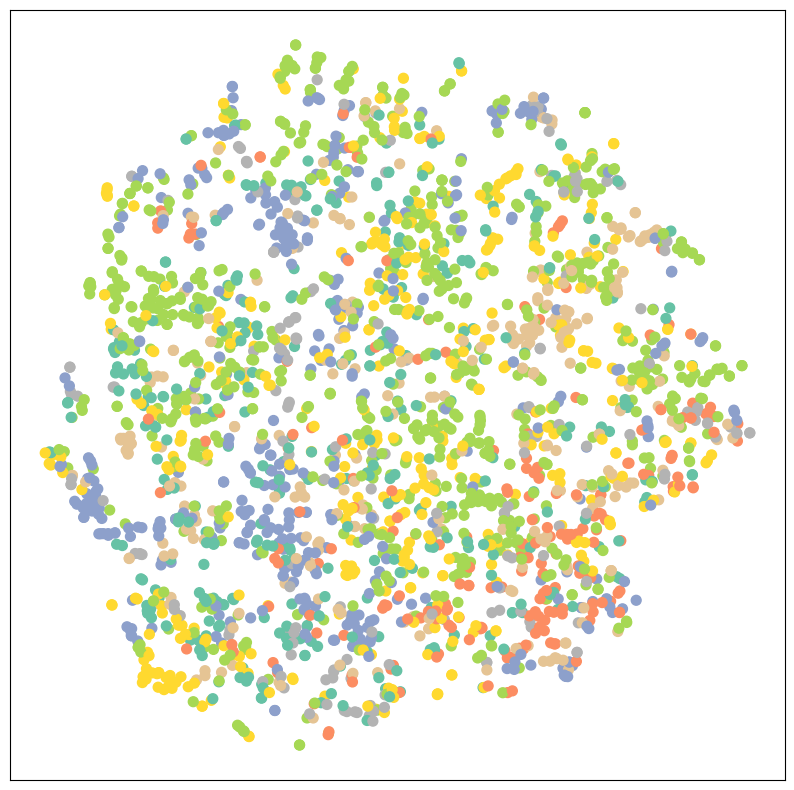

In [11]:
# Get node embeddings from untrained GCN model
model = GCN(hidden_size)
model.eval()  # we don't want to run dropout
out = model(data.x, data.edge_index)
visualize_embedding(out, color=data.y)

In [12]:
model = GCN(hidden_size)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

def train():
    model.train()  # model in training mode (dropout takes place)
    optimizer.zero_grad()  # clear gradients
    logits = model(data.x, data.edge_index)  # perform a single forward pass
    loss = criterion(logits[data.train_mask], 
                     data.y[data.train_mask])  # compute loss for training data
    train_pred = logits[data.train_mask].argmax(dim=1)  # predict class (with highest probability)
    train_correct =  train_pred == data.y[data.train_mask]   # compare with true class labels
    train_accuracy = int(train_correct.sum()) / int(data.train_mask.sum()) # get ratio of correct predictions
    loss.backward()
    optimizer.step()
    return float(loss), train_accuracy

def test():
    model.eval()  # model in eval mode (no dropout here!)
    logits = model(data.x, data.edge_index)  # get predicted logits
    test_loss = criterion(logits[data.test_mask], 
                          data.y[data.test_mask]) # loss only over test data
    y_pred = logits[data.test_mask].argmax(dim=1)  # get class (with highest probability)
    test_correct = y_pred == data.y[data.test_mask]  # compare with true class labels
    test_accuracy = int(test_correct.sum())/ int(data.test_mask.sum())  # get ratio of correct predictions
    return float(test_loss), test_accuracy, logits
    

In [13]:
for epoch in range(1, 201):
    loss, accuracy = train()
    if epoch % 10 == 0:
        print(f"Epoch: {epoch:03d}, Loss: {loss:.4f}, Acc: {accuracy:.3f}")

Epoch: 010, Loss: 1.8769, Acc: 0.743
Epoch: 020, Loss: 1.7760, Acc: 0.714
Epoch: 030, Loss: 1.6204, Acc: 0.836
Epoch: 040, Loss: 1.4216, Acc: 0.857
Epoch: 050, Loss: 1.2363, Acc: 0.843
Epoch: 060, Loss: 1.0039, Acc: 0.936
Epoch: 070, Loss: 0.9249, Acc: 0.886
Epoch: 080, Loss: 0.7583, Acc: 0.929
Epoch: 090, Loss: 0.6778, Acc: 0.900
Epoch: 100, Loss: 0.5881, Acc: 0.950
Epoch: 110, Loss: 0.5565, Acc: 0.950
Epoch: 120, Loss: 0.5387, Acc: 0.943
Epoch: 130, Loss: 0.4708, Acc: 0.971
Epoch: 140, Loss: 0.4305, Acc: 0.964
Epoch: 150, Loss: 0.3847, Acc: 0.979
Epoch: 160, Loss: 0.3898, Acc: 0.986
Epoch: 170, Loss: 0.3510, Acc: 0.971
Epoch: 180, Loss: 0.3647, Acc: 0.964
Epoch: 190, Loss: 0.3363, Acc: 0.979
Epoch: 200, Loss: 0.3278, Acc: 0.986


In [14]:
test_loss, accuracy_loss, out = test()

In [15]:
print(f"Test Loss: {test_loss:.4f}, Test Acc: {accuracy_loss:.3f}")

Test Loss: 0.7819, Test Acc: 0.813


### Visualize node embeddings from the **TRAINED** GCN model
Wow! Huge improvement.

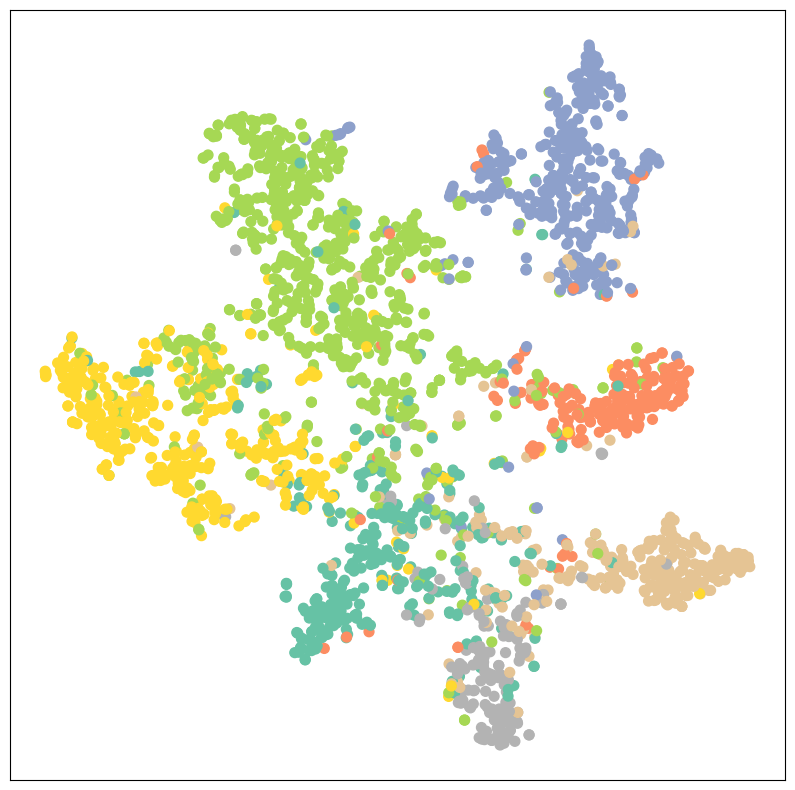

In [16]:
# All data
visualize_embedding(out, color=data.y)

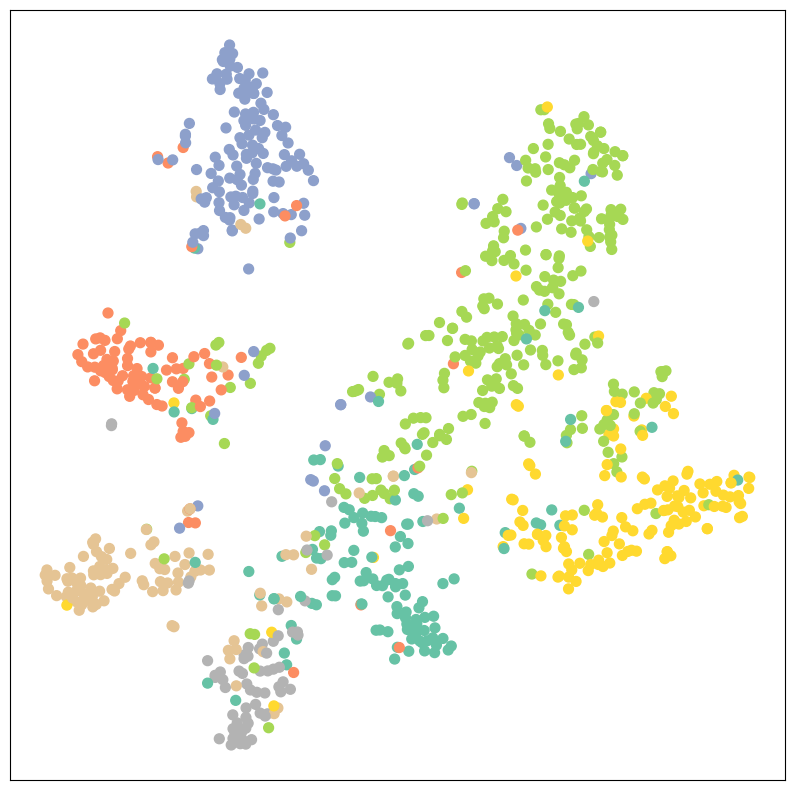

In [17]:
# only test data
visualize_embedding(out[data.test_mask], color=data.y[data.test_mask])

## Graph Neural Network - GATConv
What happens if we swap the `GCNConv` instances with [`GATConv`](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.conv.GATConv.html)?

The GATConv layer [Veličković et al. (2017)](https://arxiv.org/pdf/1609.02907.pdf) is defined as 

$$
\mathbf{x}_v^{(\ell + 1)} = \sum_{u \in \mathcal{N}(v) \, \cup \, \{ v \}} \alpha_{c_{u,v}} \mathbf{W}^{(\ell + 1)} \mathbf{x}_u^{(\ell)} $$

where 
- $\mathbf{W}^{(\ell + 1)}$ denotes a trainable weight matrix of shape `[num_output_features, num_input_features]` of a single attention head
- $\alpha_{u,v}$ is the normalized trainable attention coefficients between nodes $u$ and $v$ in a single attention head

A tutorial suggested using ELU instead of ReLU. See the difference between them here:
https://ml-cheatsheet.readthedocs.io/en/latest/activation_functions.html#elu 


In [18]:
class GAT(torch.nn.Module):
    def __init__(self, hidden_size, heads):
        super().__init__()
        torch.manual_seed(1234567)
        self.gatconv1 = GATConv(feature_size, hidden_size, heads)
        self.gatconv2 = GATConv(hidden_size * heads, num_classes, heads)
    def forward(self, x, edge_index):
        x = F.dropout(x, p=0.6, training=self.training)
        h = self.gatconv1(x, edge_index)
        h = F.elu(h)
        h = F.dropout(h, p=0.6, training=self.training)
        logits = self.gatconv2(h, edge_index)
        return logits
        
model = GAT(hidden_size=8, heads=8)
print(model)

GAT(
  (gatconv1): GATConv(1433, 8, heads=8)
  (gatconv2): GATConv(64, 7, heads=8)
)


In [19]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

In [20]:
def train():
    model.train()
    optimizer.zero_grad()
    logits = model(data.x, data.edge_index)
    loss = criterion(logits[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss

def test(mask):
    model.eval()
    test_logits = model(data.x, data.edge_index)
    test_loss = criterion(test_logits[mask], data.y[mask])
    pred = test_logits.argmax(dim=1)
    correct = pred[mask] == data.y[mask]
    accuracy = int(correct.sum()) / len(data.y[mask])
    return test_loss, accuracy, test_logits


In [21]:
# single attention head
model = GAT(hidden_size=16, heads=1)
print(model)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()
for epoch in range(1, 201):
    loss = train()
    _, val_acc, _ = test(data.val_mask)
    _, test_acc, _ = test(data.test_mask)
    if epoch % 10 == 0:
        print(f"Epoch: {epoch:03d}, Loss: {loss:.4f}, Val Acc: {val_acc:.03f}, Test Acc: {test_acc:.3f}")

GAT(
  (gatconv1): GATConv(1433, 16, heads=1)
  (gatconv2): GATConv(16, 7, heads=1)
)
Epoch: 010, Loss: 1.8519, Val Acc: 0.620, Test Acc: 0.628
Epoch: 020, Loss: 1.7243, Val Acc: 0.744, Test Acc: 0.742
Epoch: 030, Loss: 1.5312, Val Acc: 0.694, Test Acc: 0.694
Epoch: 040, Loss: 1.2532, Val Acc: 0.758, Test Acc: 0.752
Epoch: 050, Loss: 1.0506, Val Acc: 0.760, Test Acc: 0.774
Epoch: 060, Loss: 0.8409, Val Acc: 0.732, Test Acc: 0.744
Epoch: 070, Loss: 0.6887, Val Acc: 0.780, Test Acc: 0.796
Epoch: 080, Loss: 0.6325, Val Acc: 0.764, Test Acc: 0.772
Epoch: 090, Loss: 0.5211, Val Acc: 0.754, Test Acc: 0.786
Epoch: 100, Loss: 0.5202, Val Acc: 0.770, Test Acc: 0.786
Epoch: 110, Loss: 0.4989, Val Acc: 0.762, Test Acc: 0.785
Epoch: 120, Loss: 0.5264, Val Acc: 0.746, Test Acc: 0.780
Epoch: 130, Loss: 0.4144, Val Acc: 0.774, Test Acc: 0.792
Epoch: 140, Loss: 0.4083, Val Acc: 0.754, Test Acc: 0.794
Epoch: 150, Loss: 0.3367, Val Acc: 0.762, Test Acc: 0.786
Epoch: 160, Loss: 0.3932, Val Acc: 0.756, Te

In [22]:
# multi-attention heads
model = GAT(hidden_size=8, heads=8)
print(model)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()
for epoch in range(1, 201):
    loss = train()
    _, val_acc, _ = test(data.val_mask)
    _, test_acc, out = test(data.test_mask)
    if epoch % 10 == 0:
        print(f"Epoch: {epoch:03d}, Loss: {loss:.4f}, Val Acc: {val_acc:.03f}, Test Acc: {test_acc:.3f}")

GAT(
  (gatconv1): GATConv(1433, 8, heads=8)
  (gatconv2): GATConv(64, 7, heads=8)
)
Epoch: 010, Loss: 2.6638, Val Acc: 0.062, Test Acc: 0.071
Epoch: 020, Loss: 1.7918, Val Acc: 0.676, Test Acc: 0.687
Epoch: 030, Loss: 1.6560, Val Acc: 0.764, Test Acc: 0.783
Epoch: 040, Loss: 1.4799, Val Acc: 0.790, Test Acc: 0.790
Epoch: 050, Loss: 1.2377, Val Acc: 0.792, Test Acc: 0.785
Epoch: 060, Loss: 1.0593, Val Acc: 0.788, Test Acc: 0.778
Epoch: 070, Loss: 0.8795, Val Acc: 0.798, Test Acc: 0.810
Epoch: 080, Loss: 0.6811, Val Acc: 0.806, Test Acc: 0.810
Epoch: 090, Loss: 0.6716, Val Acc: 0.788, Test Acc: 0.806
Epoch: 100, Loss: 0.5296, Val Acc: 0.796, Test Acc: 0.815
Epoch: 110, Loss: 0.4759, Val Acc: 0.800, Test Acc: 0.805
Epoch: 120, Loss: 0.5084, Val Acc: 0.804, Test Acc: 0.818
Epoch: 130, Loss: 0.4638, Val Acc: 0.800, Test Acc: 0.803
Epoch: 140, Loss: 0.4685, Val Acc: 0.808, Test Acc: 0.829
Epoch: 150, Loss: 0.4141, Val Acc: 0.796, Test Acc: 0.807
Epoch: 160, Loss: 0.3261, Val Acc: 0.802, Tes

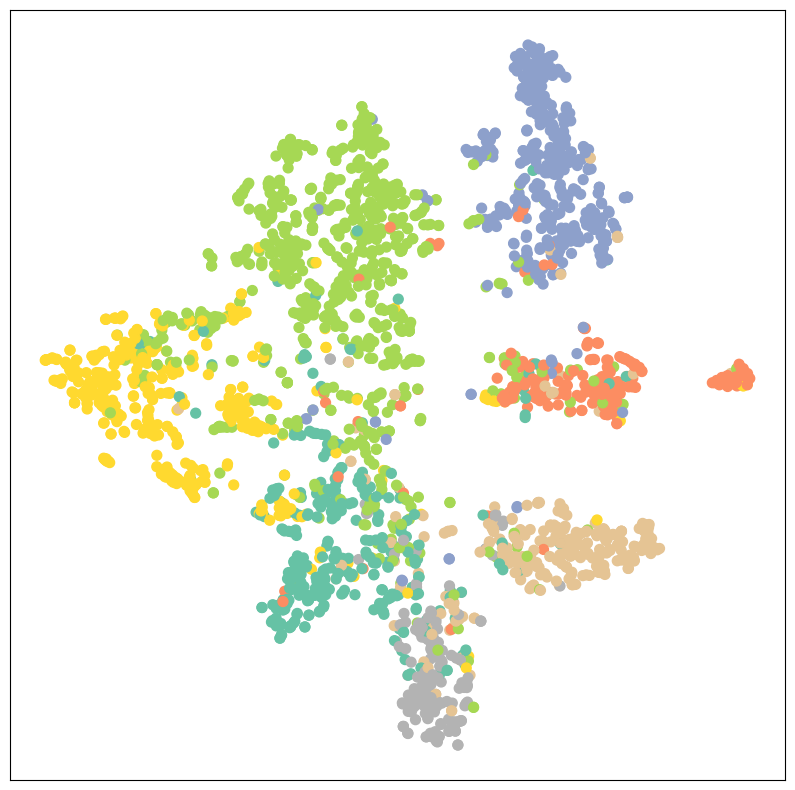

In [23]:
visualize_embedding(out, color=data.y)

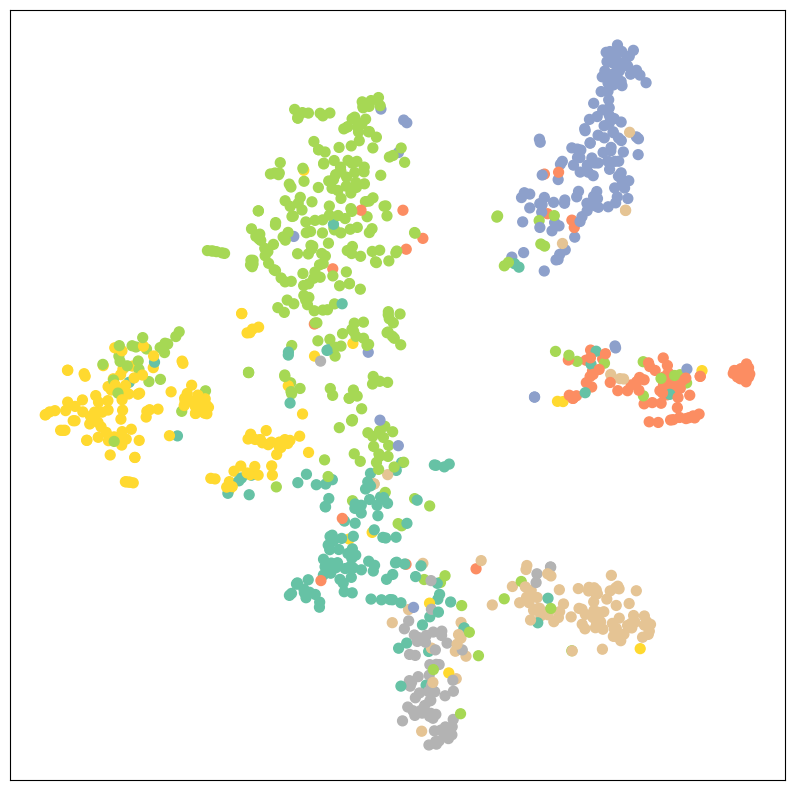

In [24]:
visualize_embedding(out[data.test_mask], color=data.y[data.test_mask])

## GCNConv vs GATConv
GCNConv and GATConv are two popular graph convolutional layers used in Graph Neural Networks (GNNs), each with its own characteristics and performance characteristics. Let's compare them based on performance and handling of inputs:

**1. Handling of Inputs:**

- **GCNConv (Graph Convolutional Network Convolution):**
  - GCNConv is designed to perform a simple weighted sum aggregation of neighboring node features.
  - It assumes that the graph is homophily, meaning that it treats all neighbors equally without considering their relationships differently.
  - It can be seen as a first-order approximation of the graph convolution operation.
  - It's computationally efficient because it operates directly on node features and doesn't involve attention mechanisms.

- **GATConv (Graph Attention Network Convolution):**
  - GATConv introduces attention mechanisms to handle node neighborhoods differently based on their importance.
  - It calculates attention scores for each neighbor and aggregates them weighted by these scores.
  - GATConv is capable of capturing more complex relationships between nodes by assigning different importance to different neighbors.
  - It can be seen as a higher-order approximation of the graph convolution operation.
  - It's computationally more intensive due to the attention mechanisms.

**2. Performance:**

- **GCNConv:**
  - GCNConv is suitable for tasks where treating all neighbors equally is a reasonable assumption.
  - It may not perform as well when nodes have highly varying degrees or when capturing fine-grained relationships between nodes is crucial.

- **GATConv:**
  - GATConv is more flexible and powerful in capturing complex graph structures.
  - It can outperform GCNConv in tasks where nodes have varying degrees and where modeling relationships with different strengths is essential.
  - GATConv's attention mechanisms allow it to adaptively focus on informative neighbors.

**3. Use Cases:**

- **GCNConv:**
  - GCNConv is a good choice for simple graph-based tasks where the homophily assumption holds, and a straightforward aggregation of neighbors is sufficient.
  - It's computationally efficient and can be used on large graphs.

- **GATConv:**
  - GATConv is well-suited for tasks that require modeling more complex relationships and capturing node-specific importance in the graph.
  - It's suitable for tasks like node classification, link prediction, and graph classification, where fine-grained information propagation is crucial.

In summary, the choice between GCNConv and GATConv depends on the specific characteristics of your graph data and the requirements of your task. If your graph has simple relationships and homophily holds, GCNConv might suffice and be computationally efficient. However, if you need to capture complex relationships and adaptively weigh the importance of neighbors, GATConv is a more suitable choice, albeit with higher computational cost. The choice should be driven by the problem you are trying to solve and the nature of your graph data.

**Homophily** refers to the tendency of nodes (individuals, entities, or vertices) in a graph to connect or form links with other nodes that share common attributes, characteristics, or interests.